In [101]:
conda install -c conda-forge optuna

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Natal\anaconda3

  added / updated specs:
    - optuna


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alembic-1.13.1             |     pyhd8ed1ab_1         155 KB  conda-forge
    colorlog-6.8.2             |  py311h1ea47a8_0          22 KB  conda-forge
    importlib_resources-6.4.0  |     pyhd8ed1ab_0          32 KB  conda-forge
    mako-1.3.3                 |     pyhd8ed1ab_0          65 KB  conda-forge
    openssl-3.0.13             |       h2bbff1b_1         7.5 MB
    optuna-3.6.0               |     pyhd8ed1ab_0         218 KB  conda-forge
    python_abi-3.11            |          2_cp311           5 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         7.9 MB

Th



==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.4.0




In [15]:
conda install -c conda-forge scikit-optimize

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Natal\anaconda3

  added / updated specs:
    - scikit-optimize


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pyaml-24.4.0               |     pyhd8ed1ab_0          27 KB  conda-forge
    scikit-optimize-0.10.1     |     pyhd8ed1ab_0          81 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         108 KB

The following NEW packages will be INSTALLED:

  pyaml              conda-forge/noarch::pyaml-24.4.0-pyhd8ed1ab_0 
  scikit-optimize    conda-forge/noarch::scikit-optimize-0.10.1-pyhd8ed1ab_0 

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2024.3.11-~ --> conda-forge::ca-certificates-2024.2.2-h



==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.3.0




In [25]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import compose, pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn import compose, pipeline
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = XGBRegressor()

### We need to play with more than just the best performing dataframe 

In [6]:
df = pd.read_csv('df_normal_quality.csv', index_col=0)

In [10]:
y = df.SalePrice
X = df.drop(['PID', 'SalePrice'], axis =1).copy()

In [80]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", drop='first')
#categorical_preprocessor2 =  OrdinalEncoder(handle_unknown="use_encoded_value", 
 #                                         unknown_value= -1) 
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)


model_pipe = Pipeline(steps=[("Preprocess", preprocessor), ("XGB", model)])

#model_regr = compose.TransformedTargetRegressor(regressor= model_pipe,
                                             #   func=np.log, inverse_func=np.exp)

#### ctrl and / to block comment
param_grid = {
    "XGB__max_depth": [3],
    "XGB__learning_rate": [.1],
    "XGB__gamma": [0],
    "XGB__reg_lambda": [1],
    "XGB__scale_pos_weight": [1],
    "XGB__n_estimators": [630],
    "XGB__reg_alpha": [.1],
    "XGB__min_child_weight": [5]
}
# param_grid = {
#    "regressor__XGB__max_depth": [3],
#    "regressor__XGB__learning_rate": [.1],
#    "regressor__XGB__gamma": [0],
#     "regressor__XGB__reg_lambda": [1],
#    "regressor__XGB__scale_pos_weight": [1],
#    "regressor__XGB__n_estimators": [630],
#    "regressor__XGB__reg_alpha": [.1],
#    "regressor__XGB__min_child_weight": [5]
# }


search = GridSearchCV(model_pipe, param_grid, n_jobs=2, cv = kf)

In [81]:
search.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('Preprocess',
                                        ColumnTransformer(transformers=[('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['GrLivArea',
                                                                          'MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'Alley',
                                                                          'LotShape',
                                                                          'LandContour',
                                                                          'Utilities',
                                                                          'LandSlope',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'Ext...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=2,
             param_grid={'XGB__gamma': [0], 'XGB__learning_rate': [0.1],
                         'XGB__max_depth': [3], 'XGB__min_child_weight': [5],
                         'XGB__n_estimators': [630], 'XGB__reg_alpha': [0.1],
                         'XGB__reg_lambda': [1], 'XGB__scale_pos_weight': [1]})

In [82]:
print(search.best_score_)
print(search.best_params_)

0.9475208034229203
{'XGB__gamma': 0, 'XGB__learning_rate': 0.1, 'XGB__max_depth': 3, 'XGB__min_child_weight': 5, 'XGB__n_estimators': 630, 'XGB__reg_alpha': 0.1, 'XGB__reg_lambda': 1, 'XGB__scale_pos_weight': 1}


In [79]:
# no normalization or standardization
#BAD
print(search.best_score_)
print(search.best_params_)

0.7258638703427457
{'XGB__gamma': 0, 'XGB__learning_rate': 0.1, 'XGB__max_depth': 3, 'XGB__min_child_weight': 5, 'XGB__n_estimators': 630, 'XGB__reg_alpha': 0.1, 'XGB__reg_lambda': 1, 'XGB__scale_pos_weight': 1}


In [58]:
# actually better without normalization 
print(search.best_score_)
print(search.best_params_)

0.9466029804510214
{'regressor__XGB__gamma': 0, 'regressor__XGB__learning_rate': 0.1, 'regressor__XGB__max_depth': 3, 'regressor__XGB__min_child_weight': 5, 'regressor__XGB__n_estimators': 630, 'regressor__XGB__reg_alpha': 0.1, 'regressor__XGB__reg_lambda': 1, 'regressor__XGB__scale_pos_weight': 1}


In [55]:
# no normalization of y
print(search.best_score_)
print(search.best_params_)

0.9475208034229203
{'XGB__gamma': 0, 'XGB__learning_rate': 0.1, 'XGB__max_depth': 3, 'XGB__min_child_weight': 5, 'XGB__n_estimators': 630, 'XGB__reg_alpha': 0.1, 'XGB__reg_lambda': 1, 'XGB__scale_pos_weight': 1}


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

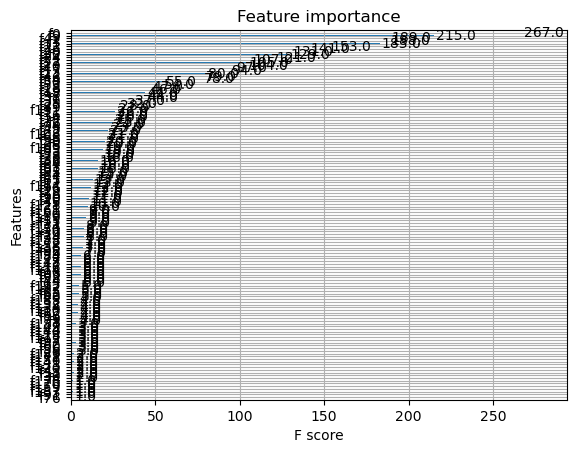

In [54]:
from xgboost import plot_importance
step = search.best_estimator_.steps[1]
model_xgb = step[1]
plot_importance(model_xgb)

In [20]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_regr, X, y, cv = kf)

C:\Users\Natal\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [3, 5, 9, 10, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Natal\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [3, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Natal\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0, 9, 14, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [16]:
# cv = 5
print(scores)
print(scores.mean())

[0.93477739 0.92694243 0.92829092 0.91772327 0.92701719]
0.9269502396258487


In [18]:
# kf
print(scores)
print(scores.mean())

[0.92915319 0.92404487 0.93558739 0.94003823 0.933943  ]
0.9325533371761544


In [21]:
# random kf state 10
print(scores)
print(scores.mean())

[0.93562852 0.93662967 0.9448388  0.88813112 0.93208987]
0.9274635946193752


### above is my initial work, below will be with search grid with bayessearch

In [8]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [98]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", drop='first')
#categorical_preprocessor2 =  OrdinalEncoder(handle_unknown="use_encoded_value", 
 #                                         unknown_value= -1) 
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)


model_pipe = Pipeline(steps=[("Preprocess", preprocessor), ("XGB", model)])

model_regr = compose.TransformedTargetRegressor(regressor= model_pipe,
                                                 func=np.log, inverse_func=np.exp)

param_grid = {
    "regressor__XGB__max_depth":  [2],
    "regressor__XGB__learning_rate": [.194],
    "regressor__XGB__colsample_bytree": [1],
    "regressor__XGB__n_estimators": Integer(650, 750),
    "regressor__XGB__reg_alpha": [.1],
    "regressor__XGB__reg_lambda": [1],
    "regressor__XGB__subsample": [.68833],
    "regressor__XGB__num_boost_round": Integer(1050, 1200),
    "regressor__XGB__min_child_weight": [6]
}

# param_grid = {
#     "regressor__XGB__max_depth": Integer(2,4),
#     "regressor__XGB__learning_rate": Real(.001, .2),
#     "regressor__XGB__scale_pos_weight": [1],
#     "regressor__XGB__colsample_bytree": Real(0, 1)
#     "regressor__XGB__n_estimators": Integer(600, 650),
#     "regressor__XGB__reg_alpha": Real(0, 2),
#     "regressor__XGB__reg_lambda": Real(0, 2),
#     "regressor__XGB__subsample": Real(0, 1),
#     "regressor__XGB__num_boost_round": Real(0, 1),
#     "regressor__XGB__min_child_weight": Integer(1, 6)
# }
#param_grid = {
#     "regressor__XGB__max_depth": Integer(2,5),
#     "regressor__XGB__learning_rate": Real(.1, .5),
#     "regressor__XGB__gamma": [0],
#     "regressor__XGB__reg_lambda": Real(0, 1),
#     "regressor__XGB__scale_pos_weight": [1],
#     "regressor__XGB__n_estimators": [630],
#     "regressor__XGB__reg_alpha": [.1],
#     "regressor__XGB__min_child_weight": Integer(1,5)
# }


opt = BayesSearchCV(model_regr, param_grid, n_jobs=2, cv = kf, random)

In [ ]:
{'XGB__gamma': 0, 'XGB__learning_rate': 0.1, 
 'XGB__max_depth': 3, 'XGB__min_child_weight': 5, 
 'XGB__n_estimators': 630, 'XGB__reg_alpha': 0.1, 
 'XGB__reg_lambda': 1, 'XGB__scale_pos_weight': 1}

In [99]:
opt.fit(X,y)

[15:24:54] WARNING: C:\b\abs_7diruzi3as\croot\xgboost-split_1712794727514\work\src\learner.cc:767: 
Parameters: { "num_boost_round" } are not used.



BayesSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                   inverse_func=<ufunc 'exp'>,
                                                   regressor=Pipeline(steps=[('Preprocess',
                                                                              ColumnTransformer(transformers=[('standard_scaler',
                                                                                                               StandardScaler(),
                                                                                                               ['GrLivArea',
                                                                                                                'MSSubClass',
                                                                                                                'LotFrontage',
                                                                                                                'LotArea',
                                                                                                                'Alley',
                                                                                                                'LotShape',
                                                                                                                'LandContour',
                                                                                                                'Utilities',
                                                                                                                'L...
                             'regressor__XGB__max_depth': [2],
                             'regressor__XGB__min_child_weight': [6],
                             'regressor__XGB__n_estimators': Integer(low=650, high=750, prior='uniform', transform='normalize'),
                             'regressor__XGB__num_boost_round': Integer(low=1050, high=1200, prior='uniform', transform='normalize'),
                             'regressor__XGB__reg_alpha': [0.1],
                             'regressor__XGB__reg_lambda': [1],
                             'regressor__XGB__subsample': [0.68833]})

In [100]:
print(opt.best_score_)
print(opt.best_params_)

0.9479832346539115
OrderedDict([('regressor__XGB__colsample_bytree', 1), ('regressor__XGB__learning_rate', 0.194), ('regressor__XGB__max_depth', 2), ('regressor__XGB__min_child_weight', 6), ('regressor__XGB__n_estimators', 749), ('regressor__XGB__num_boost_round', 1050), ('regressor__XGB__reg_alpha', 0.1), ('regressor__XGB__reg_lambda', 1), ('regressor__XGB__subsample', 0.68833)])


In [97]:
print(opt.best_score_)
print(opt.best_params_)

# param_grid = {
#     "regressor__XGB__max_depth":  [2],
#     "regressor__XGB__learning_rate": Real(.01, .2),
#     "regressor__XGB__colsample_bytree": [1],
#     "regressor__XGB__n_estimators": Integer(600, 650),
#     "regressor__XGB__reg_alpha": [.1],
#     "regressor__XGB__reg_lambda": [1],
#     "regressor__XGB__subsample": [.68833],
#     "regressor__XGB__num_boost_round": Integer(950, 1050),
#     "regressor__XGB__min_child_weight": Integer(6,8)
# }


0.9505378316905986
OrderedDict([('regressor__XGB__colsample_bytree', 1), ('regressor__XGB__learning_rate', 0.19547111281866883), ('regressor__XGB__max_depth', 2), ('regressor__XGB__min_child_weight', 6), ('regressor__XGB__n_estimators', 650), ('regressor__XGB__num_boost_round', 950), ('regressor__XGB__reg_alpha', 0.1), ('regressor__XGB__reg_lambda', 1), ('regressor__XGB__subsample', 0.68833)])


In [93]:
# param_grid = {
#     "regressor__XGB__max_depth": Integer(2,4),
#     "regressor__XGB__learning_rate": [.1],
#     "regressor__XGB__colsample_bytree": Real(0, 1),
#     "regressor__XGB__n_estimators": [630],
#     "regressor__XGB__reg_alpha": [.1],
#     "regressor__XGB__reg_lambda": [1],
#     "regressor__XGB__subsample": Real(0, 1),
#     "regressor__XGB__num_boost_round": [1000],
#     "regressor__XGB__min_child_weight": Integer(1, 6)
# } 
print(opt.best_score_)
print(opt.best_params_)

0.9500705641364512
OrderedDict([('regressor__XGB__colsample_bytree', 1.0), ('regressor__XGB__learning_rate', 0.1), ('regressor__XGB__max_depth', 2), ('regressor__XGB__min_child_weight', 6), ('regressor__XGB__n_estimators', 630), ('regressor__XGB__num_boost_round', 1000), ('regressor__XGB__reg_alpha', 0.1), ('regressor__XGB__reg_lambda', 1), ('regressor__XGB__subsample', 0.6883302642344166)])


In [89]:
# with normalization 
print(opt.best_score_)
print(opt.best_params_)

0.9473824700311871
OrderedDict([('regressor__XGB__gamma', 0), ('regressor__XGB__learning_rate', 0.17396182684218464), ('regressor__XGB__max_depth', 2), ('regressor__XGB__min_child_weight', 6), ('regressor__XGB__n_estimators', 650), ('regressor__XGB__reg_alpha', 0.1), ('regressor__XGB__reg_lambda', 6.525476697924969), ('regressor__XGB__scale_pos_weight', 1)])


In [86]:
# this is without normalization 
print(opt.best_score_)
print(opt.best_params_)

0.9474189303556209
OrderedDict([('XGB__gamma', 0), ('XGB__learning_rate', 0.06691230775203803), ('XGB__max_depth', 3), ('XGB__min_child_weight', 5), ('XGB__n_estimators', 601), ('XGB__reg_alpha', 0.1), ('XGB__reg_lambda', 1.0667388136737757), ('XGB__scale_pos_weight', 1)])


In [26]:
# kf randomstate  is 10
print(opt.best_score_)
print(opt.best_params_)

0.9502283773923905
OrderedDict([('regressor__XGB__gamma', 0), ('regressor__XGB__learning_rate', 0.1), ('regressor__XGB__max_depth', 3), ('regressor__XGB__min_child_weight', 5), ('regressor__XGB__n_estimators', 630), ('regressor__XGB__reg_alpha', 0.1), ('regressor__XGB__reg_lambda', 1.0), ('regressor__XGB__scale_pos_weight', 1)])


In [10]:
# kf random state 42 I think gave these 
print(opt.best_score_)
print(opt.best_params_)

0.9478653411032253
OrderedDict([('regressor__XGB__gamma', 0), ('regressor__XGB__learning_rate', 0.10060991347716391), ('regressor__XGB__max_depth', 2), ('regressor__XGB__min_child_weight', 2), ('regressor__XGB__n_estimators', 630), ('regressor__XGB__reg_alpha', 0.1), ('regressor__XGB__reg_lambda', 0.049358074984923186), ('regressor__XGB__scale_pos_weight', 1)])


In [45]:
opt.best_estimator_.steps

AttributeError: 'TransformedTargetRegressor' object has no attribute 'steps'

In [ ]:
{'regressor__XGB__gamma': 0, 'regressor__XGB__learning_rate': 1, 
 'regressor__XGB__max_depth': 8, 'regressor__XGB__min_child_weight': 4, 
 'regressor__XGB__n_estimators': 1, 'regressor__XGB__reg_alpha': 0,
 'regressor__XGB__reg_lambda': 0, 'regressor__XGB__scale_pos_weight': 1}

### feature importance below

In [51]:
from xgboost import plot_importance
#opt.best_estimator_

In [ ]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [52]:
opt.best_estimator_

AttributeError: 'TransformedTargetRegressor' object has no attribute 'steps'

### Optuna

In [ ]:
# model_opt = xgb.XGBRegressor(**params)
# model_pipe = Pipeline(steps=[("Preprocess", preprocessor), ("XGB", model_opt)])
# model_regr = compose.TransformedTargetRegressor(regressor= model_pipe,
#                                                  func=np.log, inverse_func=np.exp)
# model_cross = cross_val_score(model_regr, X, y, cv = kf, error_score= 'raise')
# model_cross.fit(X, y, verbose=False)

In [116]:
# import optuna

# def objective(trial):
#     params = {
#         "objective": "reg:squarederror",
#         "n_estimators": 1000,
#         "verbosity": 0,
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
#         "max_depth": trial.suggest_int("max_depth", 1, 10),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
#     }
    
#     model_opt = xgb.XGBRegressor(**params)
#     model_pipe = Pipeline(steps=[("Preprocess", preprocessor), ("XGB", model_opt)])
#     model_regr = compose.TransformedTargetRegressor(regressor= model_pipe,
#                                                  func=np.log, inverse_func=np.exp)
#     model_cross = cross_val_score(model_regr, X, y, cv = kf, error_score= 'raise')
#     model_cross.fit(X, y, verbose=False)
#     return model_cross.best_score_

In [118]:
from optuna import Trial

def choose_columns(trial : Trial, columns : list[str]) -> list[str]:
  choose = lambda column: trial.suggest_categorical(column, [True, False])
  choices = [*filter(choose, columns)]
  return choices

In [119]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge


Classifier = (
  RandomForestClassifier |
  XGBRegressor |
  Ridge
)

def instantiate_learner(trial : Trial) -> Classifier:
  algorithm = trial.suggest_categorical(
    'algorithm', ['random_forest', 'xgb', 'ridge']
  )
  if algorithm=='random_forest':
    model = instantiate_logistic_regression(trial)
  elif algorithm=='xgb':
    model = instantiate_random_forest(trial)
  elif algorithm=='ridge':
    model = instantiate_extra_forest(trial)
  
  return model